# Importation des Librairies Utiles

In [68]:
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pymongo
import numpy as np 
import math
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D


#### Fonction optimisant le calcul du silhouette score 

# Importation des données

Nos données sont toutes stockées dans une base de donnée mongoDB. Afin de pouvoir importer nos données pour pouvoir les traiter, nous devons donc nous connecter à la base de donnée **Tweet** puis à sa collection **`users`**.


In [69]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["Tweet"]
user_collection = db["users"]

# Récupération des données

Afin d'avoir la main sur les données et rendre plus souple la manipulation, nous importons toutes les données dans un objet de type `dataframe` grâce à la librairie `pandas`

In [70]:
users = list(user_collection.find({}))
users = pd.DataFrame(users)

## Suppression des colonnes non utilisées lors du kmeans

les avriables `_id`, `last_tweet_published_id`,`tweet_ids` sont de referneces qui ous ont permis d'extraires les atributs de nos utilisateurs. Elles n'etant plus très necessaire  par la suite nous alons les suprimés
 
On retire toutes les colonnes qui ne sont pas des attributs de nos utilisateurs.  
De plus supprime l'attribut tweet_frequency de nos données sachant qu'il est corrélé avec l'agressivité. Ce paramètre n'apporte pas d'informations supplémentaires. Une visualisation de cette corrélation peut être observée dans le script ``previewData``

In [71]:
users = pd.DataFrame(users)
users.index = users.user_id
users = users.drop(columns=["_id","user_id","last_tweet_published_id","tweet_ids","friends_count","followers_count","tweet_frequency"])
users.head()

,hashtag_frequency,verified,statuses_count,favourites_count,age_account,ratio_friends_followers,avg_tweet_length,nb_sensitive_tweets,Ap,visibility,ratio_sensitive_tweets,ratio_punctuation_tweets,avg_tweet_levenshtein_similarity
user_id,,,,,,,,,,,,,
39084553,2.00,0,32153,17414,3325.047222,1.485612,140.0,0,0.001151,0.190383,0.0,0.064286,0.000000
1564678657,0.00,0,28445,15412,1810.680359,0.747277,51.0,0,0.001870,0.000000,0.0,0.137255,0.000000
4872447178,1.75,0,5168,144,865.995127,1.136088,135.0,0,0.000711,0.157138,0.0,0.045238,82.333333
967244973824339968,0.00,0,4232,2135,113.633403,1.294118,37.0,0,0.004436,0.037790,0.0,0.183230,31.000000
35628099,2.00,0,487,1124,3338.729039,8.479167,140.0,0,0.000017,0.265963,0.0,0.064286,0.000000


In [72]:
# users.describe()

## Standardisation des données via sklearn

¨Pour Ainsi pour chaque valeurs $x_{ij}$, on obtiendra la valeur centrée suivante :
 $$ X^{centré} = \frac{X - \bar{X}}{\sigma(X)}$$

Pour réaliser cette opération, nous nous servons de l'objet **StandardScaler** qui provient de la librairie scikit-learn

In [73]:
scaler = StandardScaler()
user_scale = pd.DataFrame(scaler.fit_transform(users), columns = users.columns)

Fonctions optimisant le calcul du score de silhouette

## Réalisation de l'ACP


In [74]:
# Instansiation de la classe PCA en objet pca
pca = PCA()

In [75]:
result = pca.fit_transform(user_scale)

Stockage du résultat de l'ACP dans un dataframe avec les noms de colonnes CP1, CP2... CP1 = composante 1

In [76]:
n,m = users.shape
liste = []
for i in range(1,14):
    liste.append(f"CP{i}")
result = pd.DataFrame(result, columns = liste)

### Détermination des valeurs propres


La variance calculé avec le module `PCA` est celle donnée par l'estimateur sans biais  definie par la formule $\sigma^2 = \frac{1}{n-2}\sum_ {i=1}^ {n} (x_i -\bar{x})^2  $ 

Un ajustement est nécessaire pour avoir la variance avec n degrés de liberté.

In [77]:
variance = pca.explained_variance_
# Un ajustement est nécessaire pour avoir la variance avec n degrés de liberté
eigval = variance*(len(user_scale)-1)/len(user_scale)  
print(eigval)
print(f"Et on a la somme des valeures propre egale  à :{np.sum(eigval, axis =0)}")

[2.06463057 1.9717805  1.50375907 1.32532207 1.18800575 0.97675107
 0.9462987  0.851209   0.73326933 0.6436639  0.37402691 0.29226777
 0.12901536]
Et on a la somme des valeures propre egale  à :12.999999999996758


### Détermination du nombre de dimensions à retenir
#### Diagramme en Bar de valeurs propres
Afin de pouvoir choisir le nombre de composantes à retenir, Nous allons d'abord nous interesser au diagramme en Bar des valeurs propre. Mathematiquement une valeure propre nulle implique que la dimension qui est portée par cette valeur propre ne conserve aucune information sur les données d'origine.

Ainsi,nous effectuons le diagramme des valeurs propres Rangées dans l'ordre decroissant

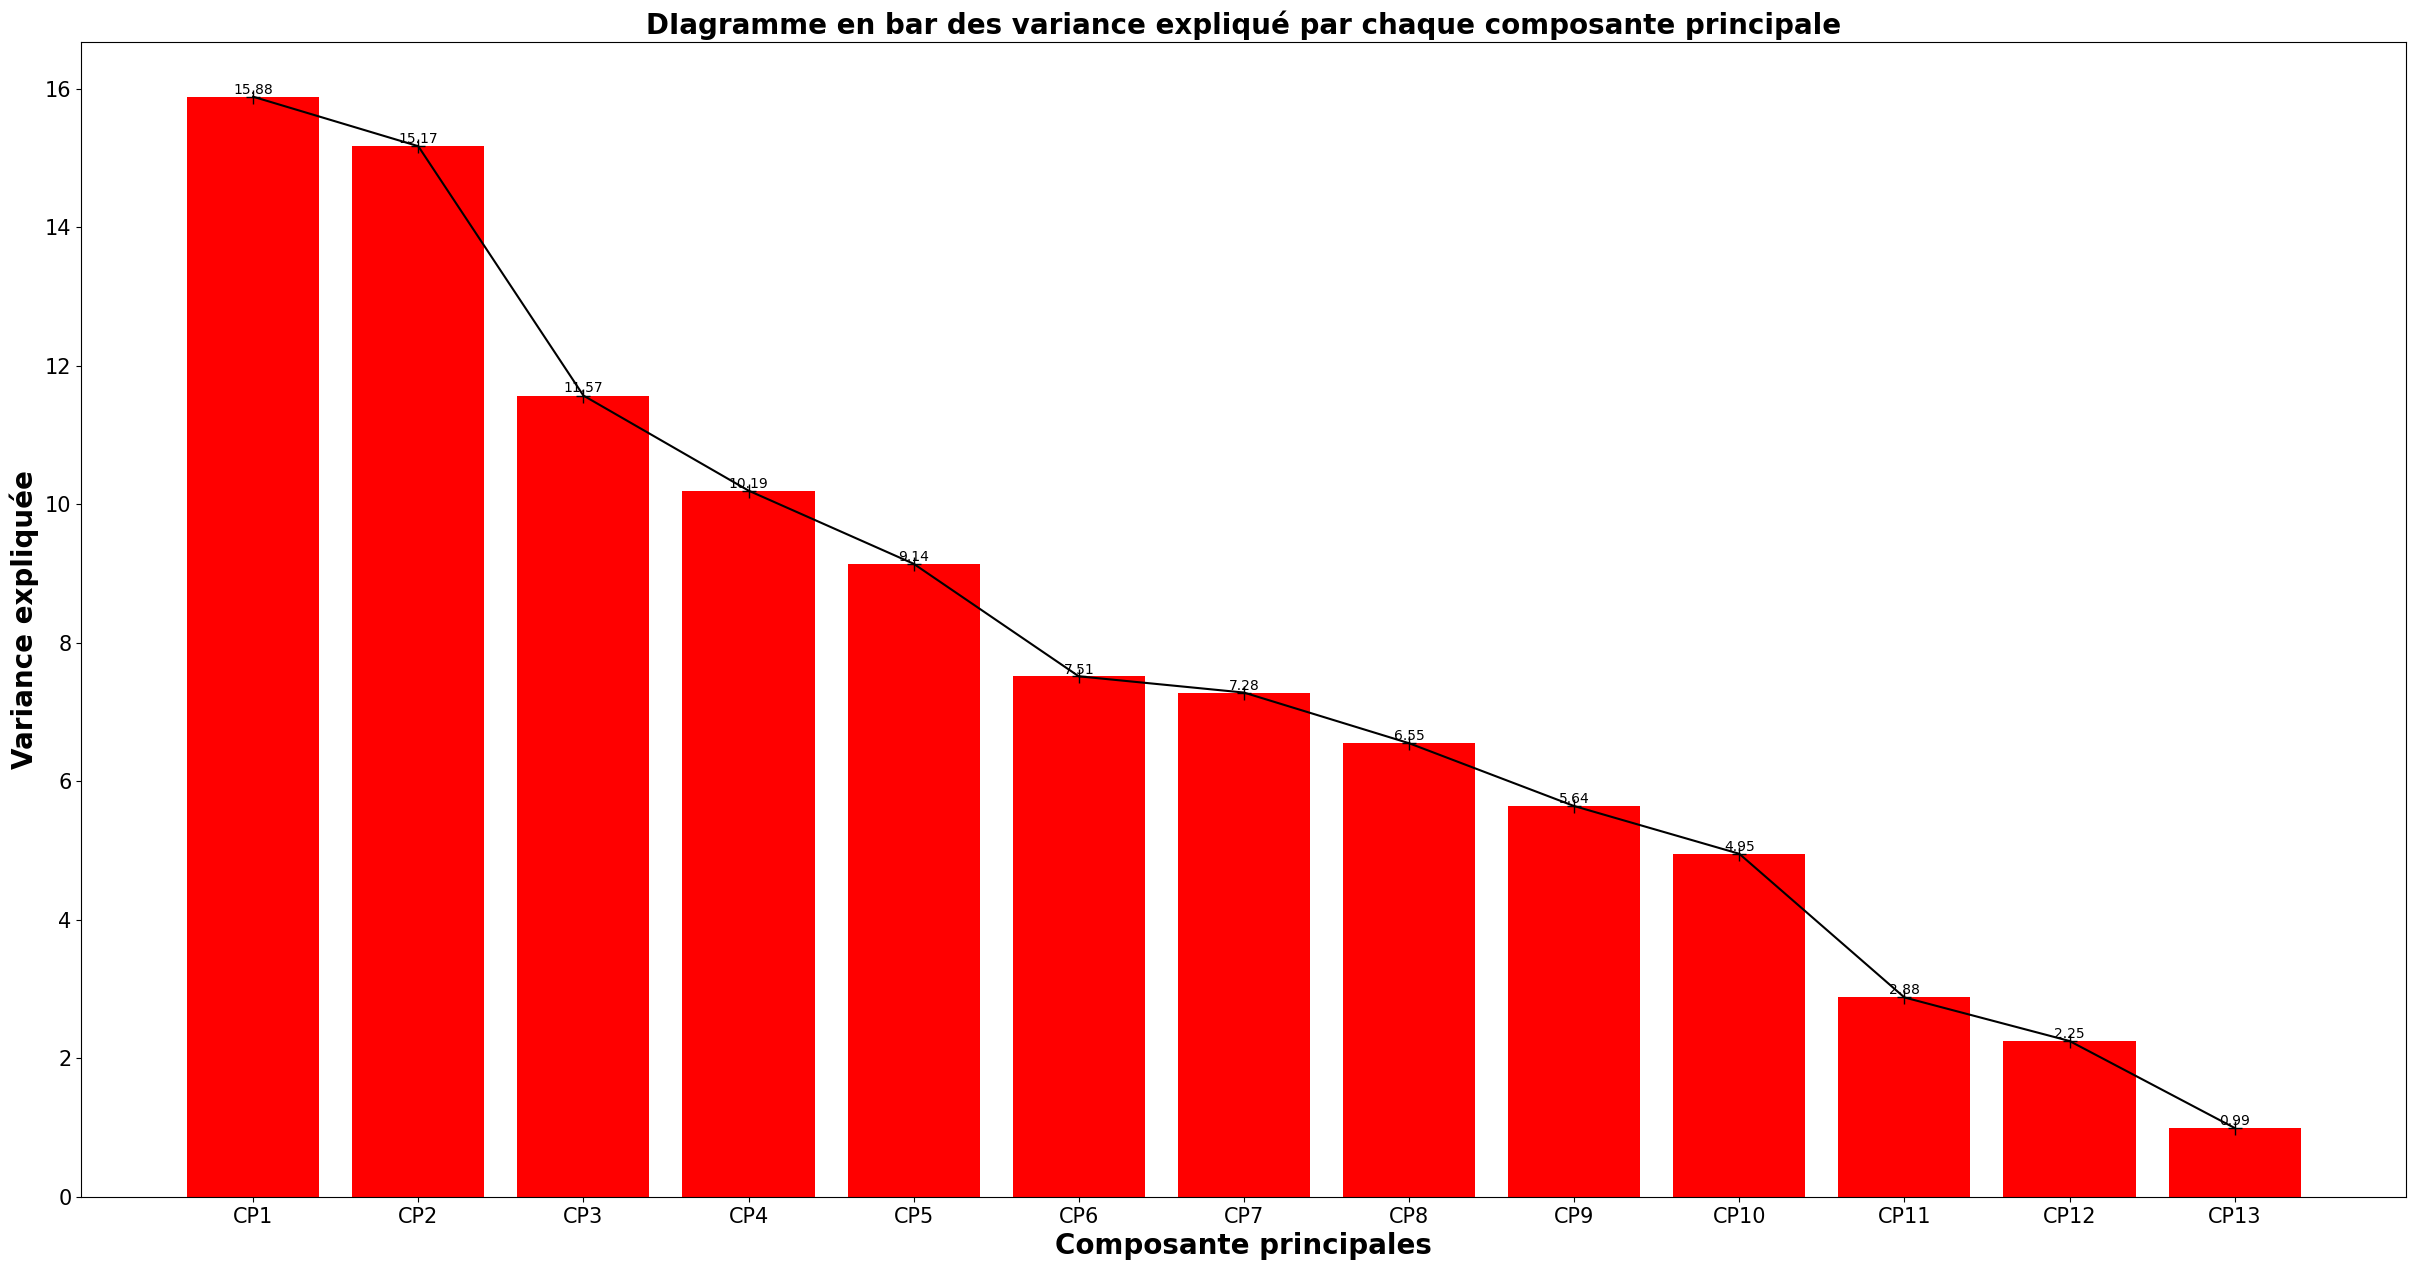

In [78]:
#ratio de la variance expliqué est % vaut 
# sns.barplot(
#     y = 
#     x = liste
# )
#creation de la fiqure et des axes
fig, ax = plt.subplots(figsize=(30, 15))

# On  trace les diagrammes
ax.bar(liste,pca.explained_variance_ratio_*100, color='r')


ax.plot(pca.explained_variance_ratio_*100, marker='+', color='black', ms=10)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)

#enumerzation des valeures sur les bar
for i, v in enumerate(pca.explained_variance_ratio_*100):
    plt.text(i, round(v,2), str(round(v,2)), ha='center', va='bottom')
    
# Affichage des layout
plt.title("DIagramme en bar des variance expliqué par chaque composante principale", fontweight = "bold",fontsize = 20)
plt.xlabel("Composante principales", fontweight = "bold",fontsize = 20)
plt.ylabel("Variance expliquée", fontweight = 'bold',fontsize = 20)
plt.show()

an appliquant le principe de  on peut donc retenir que : .....

## Scree Plot

La regle de coude est Utilisé en Analyse en Composante Pricipales pour determiner le nombre de variables à garder pour l'analyse. Le `Coude` est le point où l'ajout d'une composante supplémentaire ne contribue pas de manière significative à la variance expliquée c'est à dire le point où l'augmentation de la variance expliquée devient moins importante par rapport aux composantes précédentes.

La regle de coude consiste donc à choisir le nombre de variable juste avant le coude

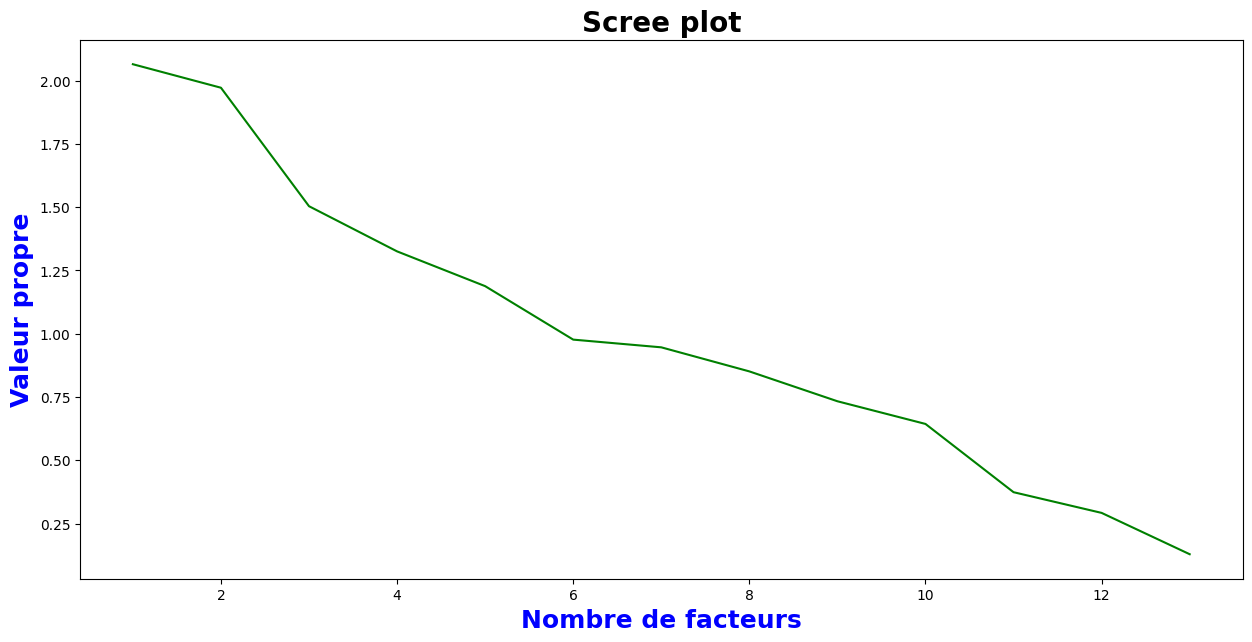

In [79]:
# Scree plot : éboulis des valeurs propres
plt.figure(figsize=(15,7))
plt.plot(np.arange(1,m+1),eigval, color='green')

#Title
plt.title("Scree plot",fontweight = "bold",fontsize= 20)

#Labels
plt.ylabel("Valeur propre", fontweight = "bold",fontsize = 18, color = 'blue')
plt.xlabel("Nombre de facteurs", fontweight = "bold",fontsize = 18, color = 'blue')


plt.show()

L aregle du coude nous permet de ne retenir que .... variables

### Cumul de la variance expliquées par chaques dimensions

Le cumul de la variance expliqué est un indicateurs aussi dans la selection des variables

Ainsi on traçe le graphe du cumul de la variance des valeurs propres, On pourra s'interres aux premierres composantes qui explique le maximum de variances

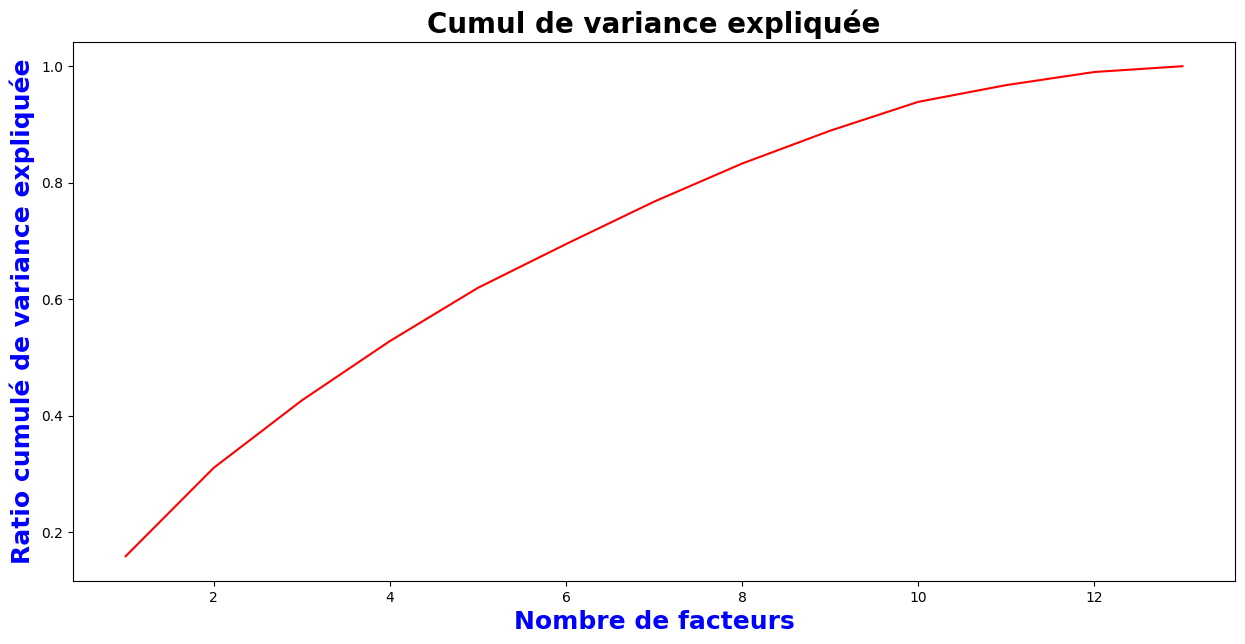

In [80]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(1,m+1),np.cumsum(pca.explained_variance_ratio_),color='red')

#Title
plt.title("Cumul de variance expliquée", fontweight = "bold",fontsize= 20)

# Labels
plt.ylabel("Ratio cumulé de variance expliquée" , fontweight = "bold",fontsize = 18, color = 'blue')
plt.xlabel("Nombre de facteurs" , fontweight = "bold",fontsize = 18, color = 'blue')

# plt.xticks(np.arange(1, m+1))
plt.show()



Ici on obtien environs `90%` de la variances avec 10 variables

### Critère de Kaiser
Un autre critère pour déterminer le nombre de dimensions à retenir est le critère de Kaiser. Selon le principe de Kaiser on peut conserver que les dimensions protées par des valeurs propres supérieures à 1 dans le cas des données centré-réduit.
Puisque nous avons stadardisé nos données nous somme legitimme à utiliser ce critère

In [81]:
nb_composante = 0

for valeur_propre in eigval:
    if valeur_propre > 1:
        nb_composante=nb_composante+1


print("le nombre de dimension retenues est : ", nb_composante)

le nombre de dimension retenues est :  5


# On reeffectue l'ACP  en tenant en compte les composantes sélectionnées par le critère de Kaiser

In [82]:
acp = PCA(n_components=nb_composante)
acp_coord = acp.fit_transform(user_scale)

### Analyse de l'ACP

In [83]:
# Calcul de la matrice des Valeures Propres
vp_mat= acp.components_.T

# On calcule la racine carrée des valeurs propres
acp_eigvalues = acp.explained_variance_*(len(user_scale)-1)/len(user_scale)
sqrt_eigval = np.sqrt(acp_eigvalues)

# Corrélation des variables avec les axes
corr_var = np.zeros((13,nb_composante))
for k in range(nb_composante):
     corr_var[:,k] = vp_mat[:,k] * sqrt_eigval[k]
        
#Construction d'un DataFrame de Correlation
corr_var_df = pd.DataFrame(corr_var)

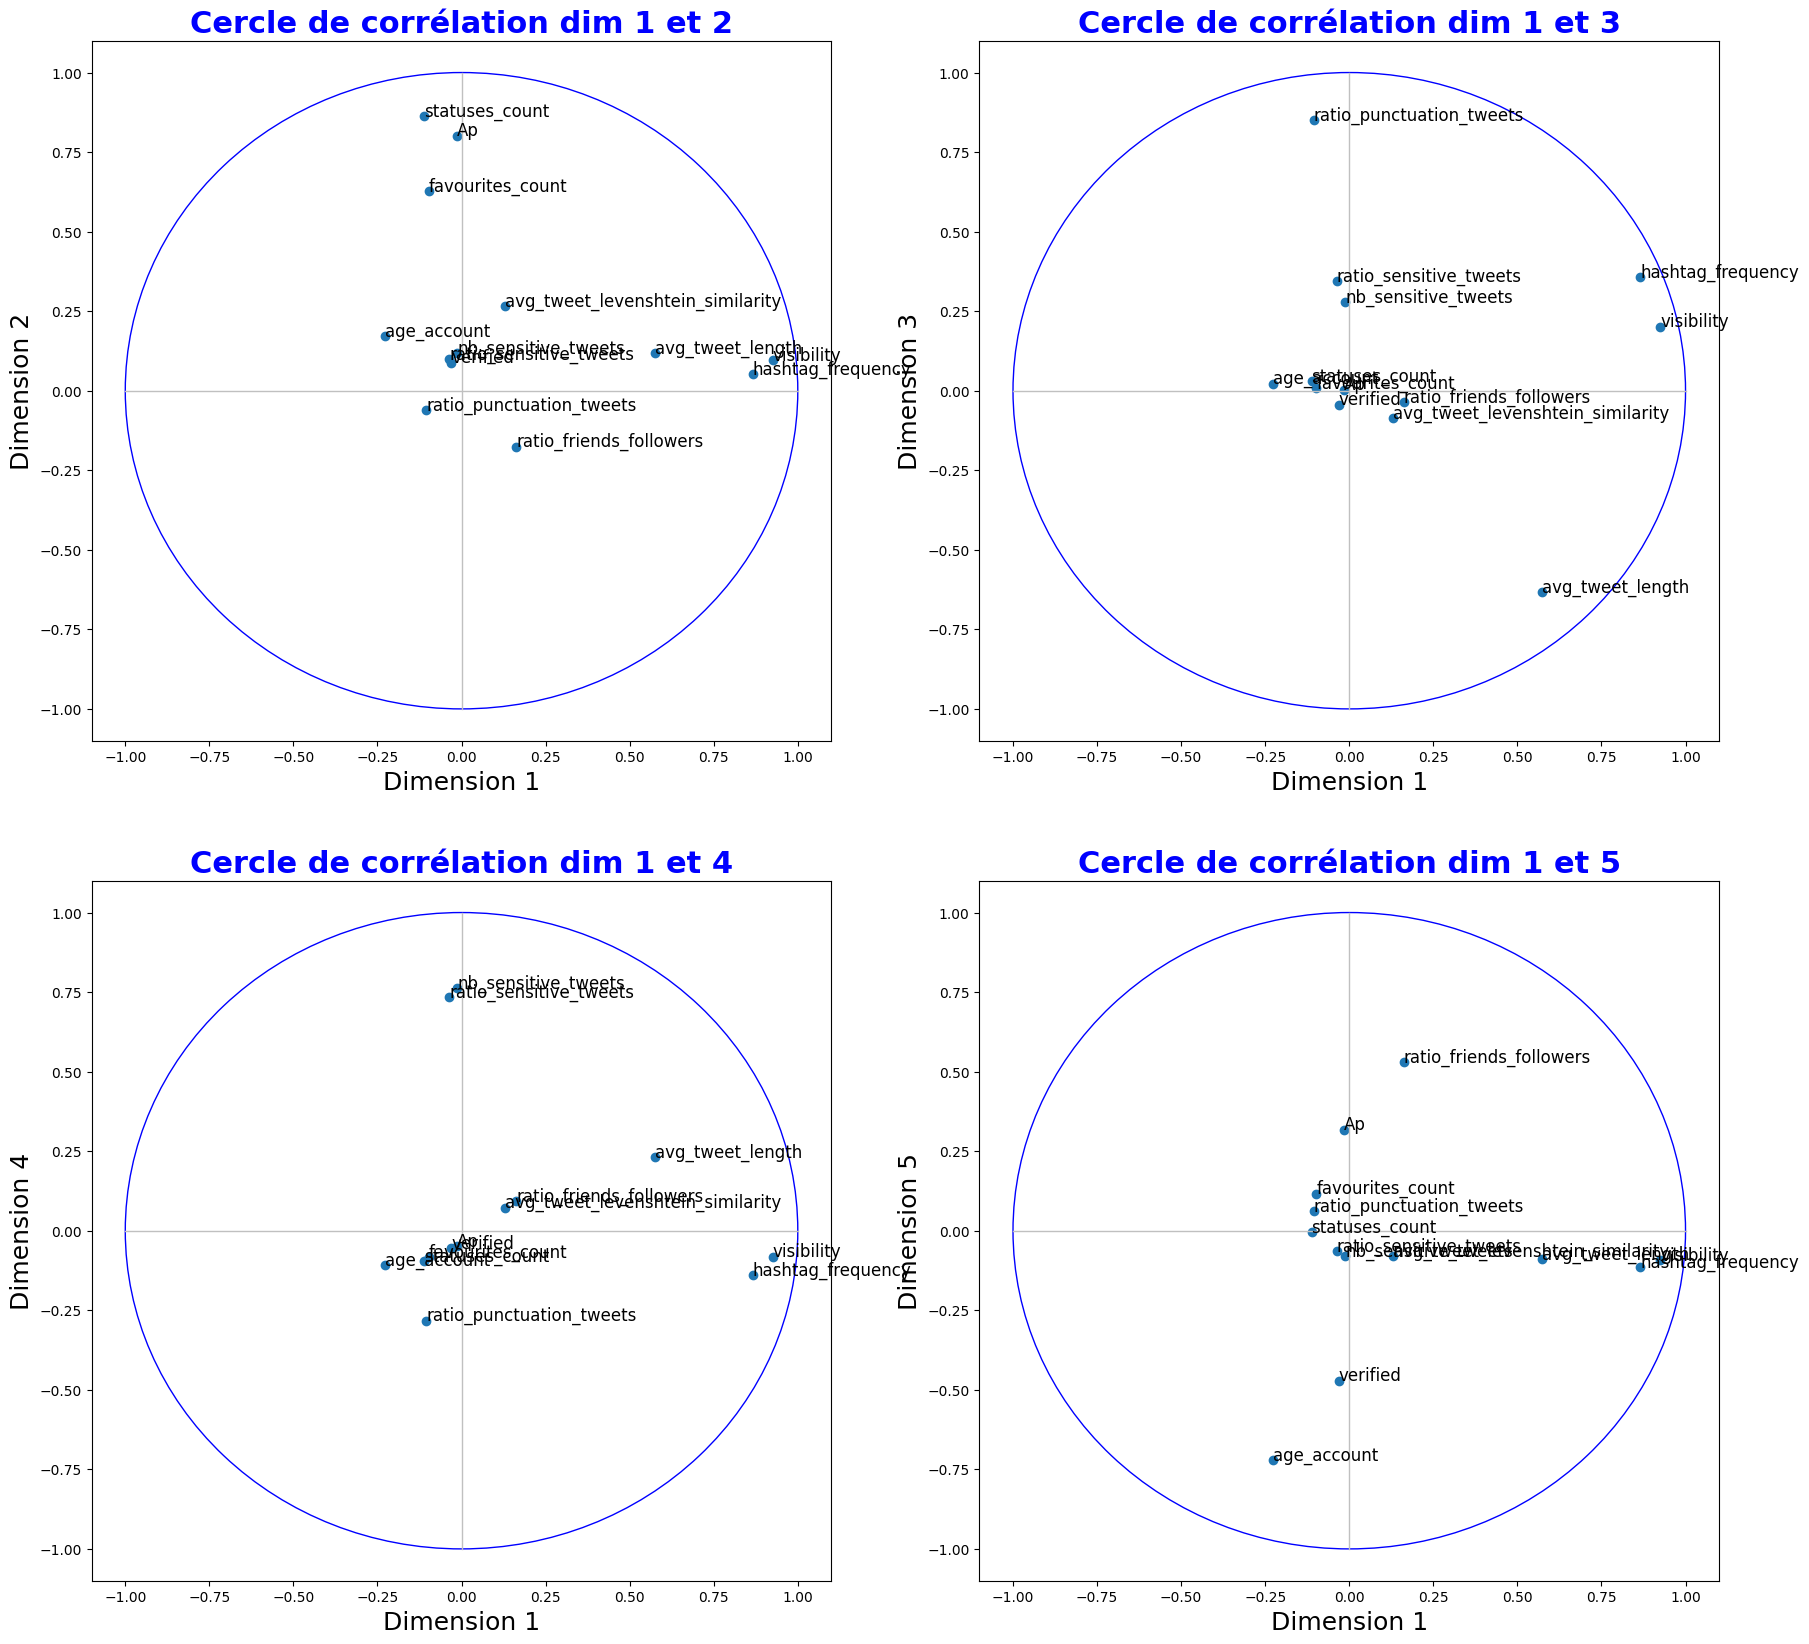

In [84]:
# Cercle des corrélations pour les deux premiers axes

cols = 2
rows = math.ceil( (nb_composante - 1) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(21, 20))

row = 0
col = -1

for dim in range(1, nb_composante):
    col += 1
    # les points
    axes[row][col].scatter(corr_var[:,0],corr_var[:,dim])
    axes[row][col].set_title(f'Cercle de corrélation dim 1 et {dim+1}', fontsize=22, color= 'blue', fontweight='bold')
    axes[row][col].set_xlabel(f'Dimension 1', fontsize=18)
    axes[row][col].set_ylabel(f'Dimension {dim+1}', fontsize=18)

    # affichage des Noms des Variables
    for j in range((len(user_scale.columns))):
        axes[row][col].annotate(user_scale.columns[j],(corr_var[j,0],corr_var[j, dim]), fontsize= 12)

    # ajouter les axes
    axes[row][col].plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
    axes[row][col].plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

    # ajouter le cercle
    cercle = plt.Circle((0,0),1,color='blue',fill=False)
    axes[row][col].add_artist(cercle)
    if col % cols == cols - 1:
        col = -1
        row += 1

#affichage
plt.show()

#### Contributions des variables aux dimensions

$CTR_{jk}$ la contribution de la variable j à la construction de l'axe $k$ est calculée comme suit :

$$CTR_{jk}=\frac{r_{jk}^{2}}{\lambda_{k}}$$

tel que $r_{jk}$ représente la corrélation de la variable $j$ avec l'axe $k$ (que nous avons récupéré dans la variable corvar) et $\lambda_{k}$ represente la valeur propre associée à l'axe $k$.

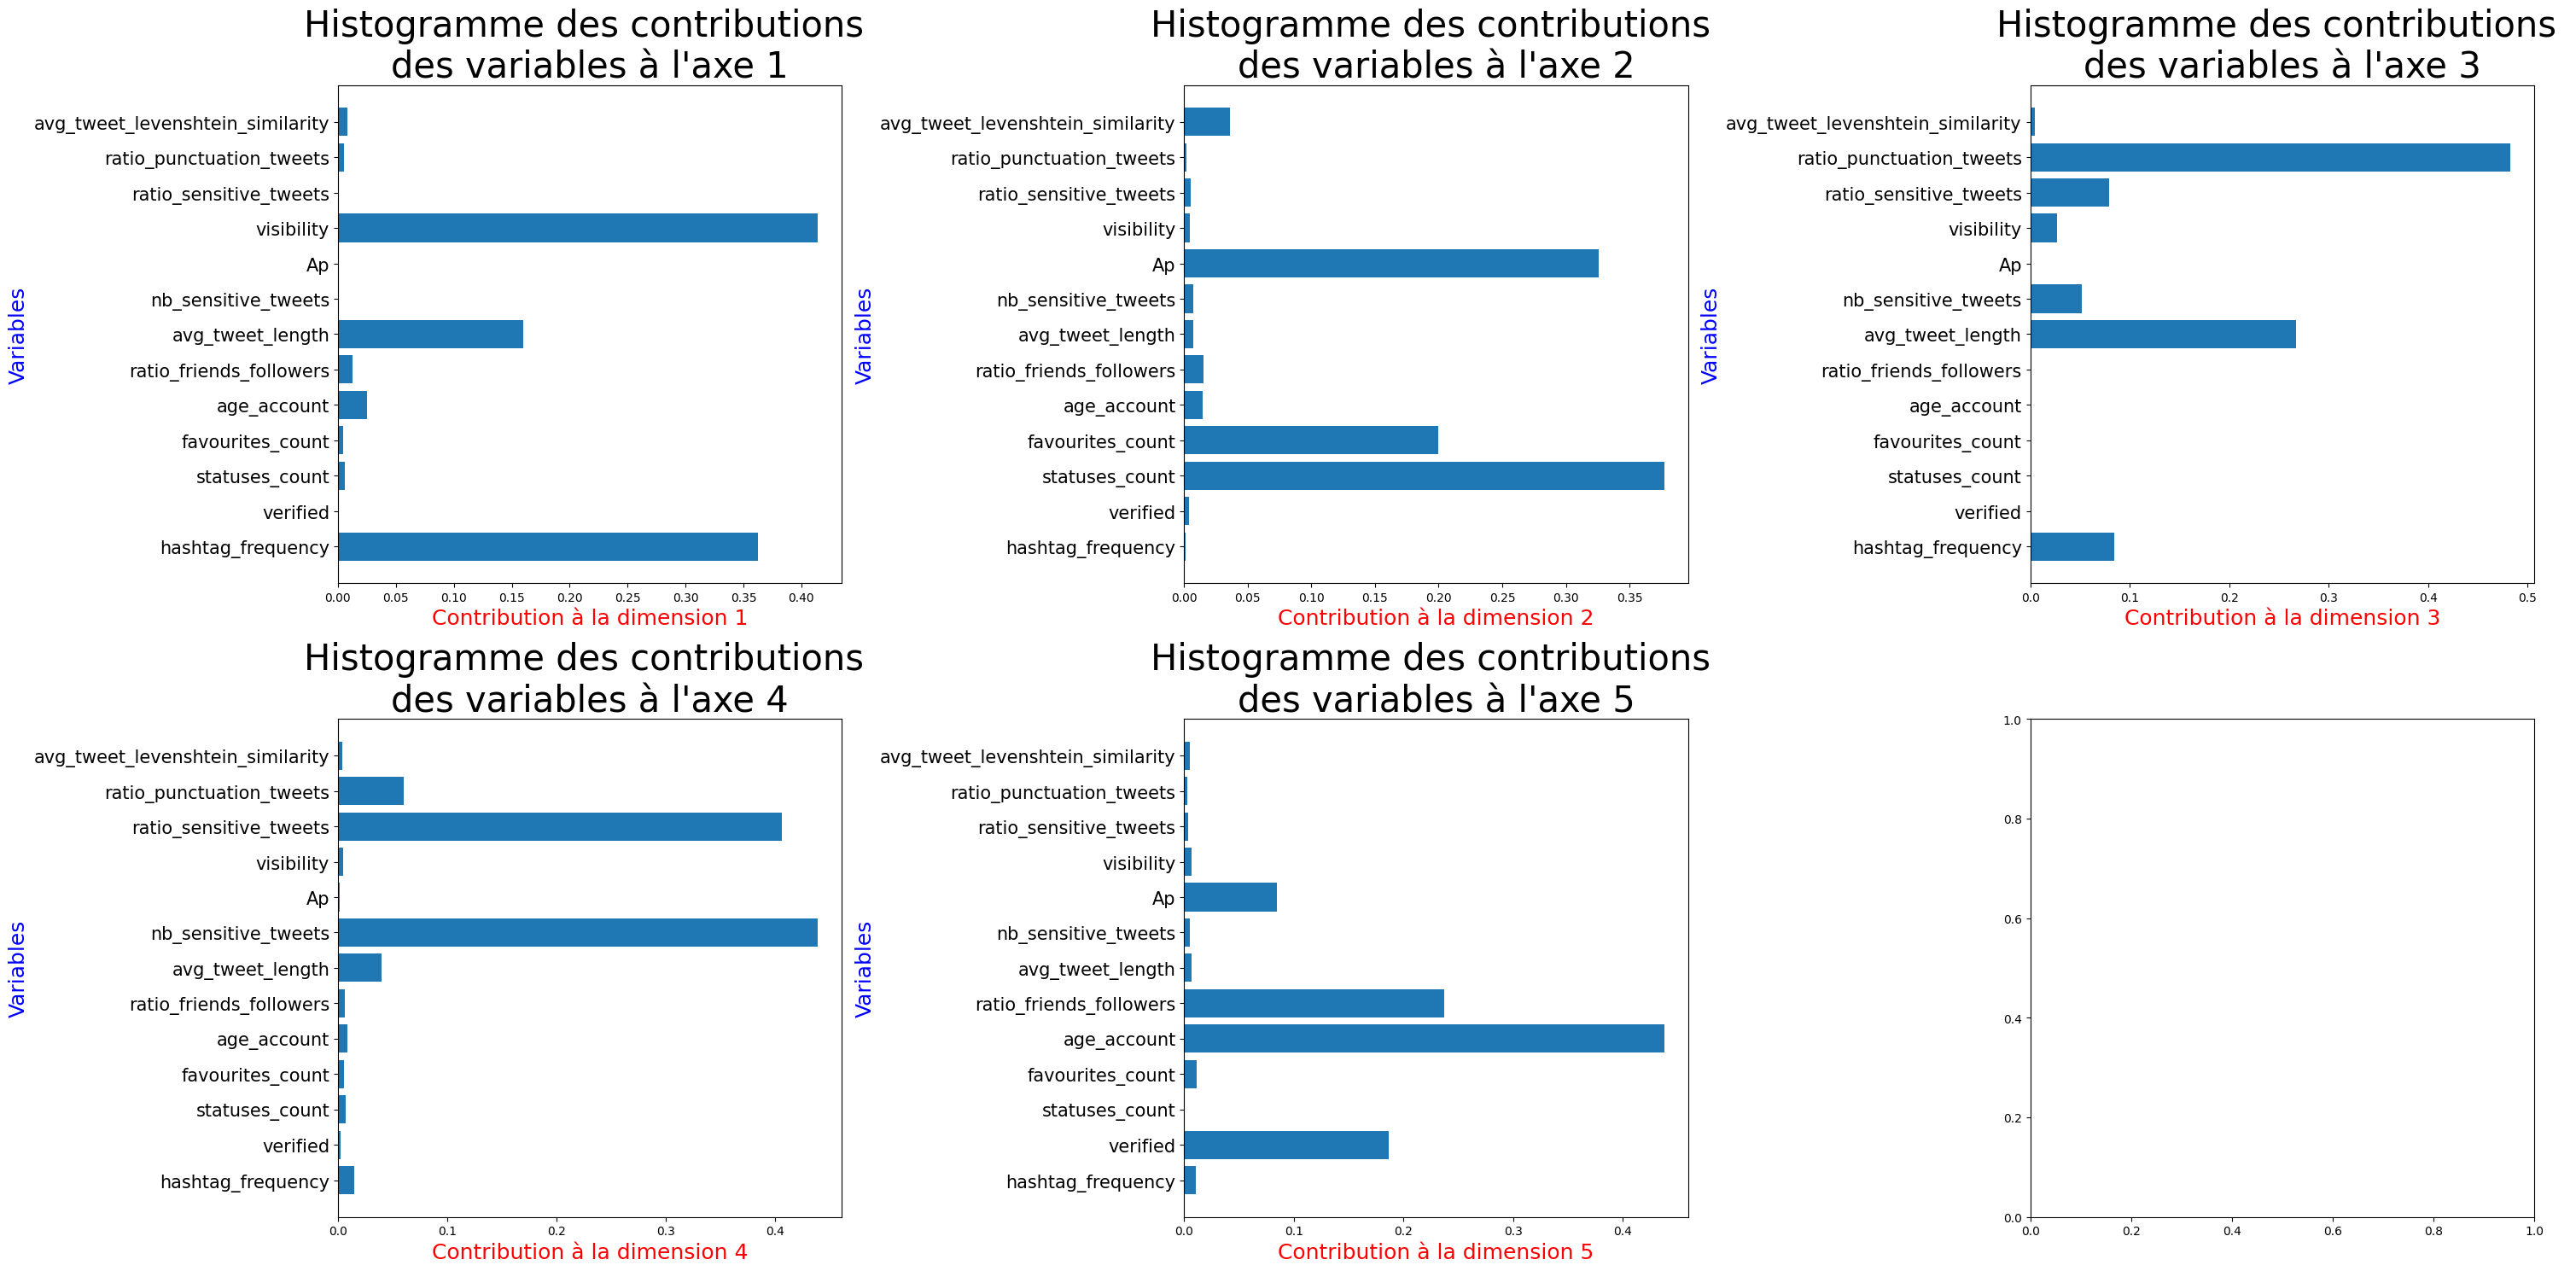

In [85]:
# Calcul des Contributions des variables à la formation des Axes

ctr_var = corr_var**2
for j in range(acp.n_components_):
    ctr_var[:,j]=ctr_var[:,j]/acp_eigvalues[j]


    
# ctr_var_df = pd.DataFrame(ctr_var[:,0:3], columns=['Contribution Axe 1', 'Contribution Axe 2','Contribution Axe 2'],users.columns)

# Contributions des variables aux axes
ctr_var = corr_var**2
for j in range(acp.n_components_):
    ctr_var[:,j]=ctr_var[:,j]/acp_eigvalues[j]
    
var_contrib_df = pd.DataFrame({f'CTR_{acp_dim+1}':ctr_var[:,acp_dim] for acp_dim in range(nb_composante)}, index=users.columns)


cols = 3
rows = math.ceil( (nb_composante - 1) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(30,15))

row = 0
col = -1
num_var = np.arange(len(var_contrib_df))

for contrib in range(len(var_contrib_df.columns)):
    col += 1
    # les points
    axes[row][col].barh(num_var, var_contrib_df[f'CTR_{contrib+1}'], align='center')
    axes[row][col].set_yticks(num_var)
    axes[row][col].set_yticklabels(var_contrib_df.index, fontsize = 15)
    axes[row][col].set_title(f'Histogramme des contributions \ndes variables à l\'axe {contrib+1}', fontsize=30)
    axes[row][col].set_xlabel(f'Contribution à la dimension {contrib+1}', fontsize=18, color = 'red')
    axes[row][col].set_ylabel(f'Variables', fontsize=18, color ='blue')
    if col % cols == cols - 1:
        col = -1
        row += 1

fig.tight_layout()

plt.show()

### Qualité de représentation des variables


$COS_{jk}$ la qualité de représentation de la variable j dans l'axe $k$ est calculée comme suit :

$$COS_{jk}^{2}=r_{jk}^2$$

tel que $r_{jk}$ représente la corrélation de la variable $j$ avec l'axe $k$ (que nous avons récupéré dans la variable corvar).



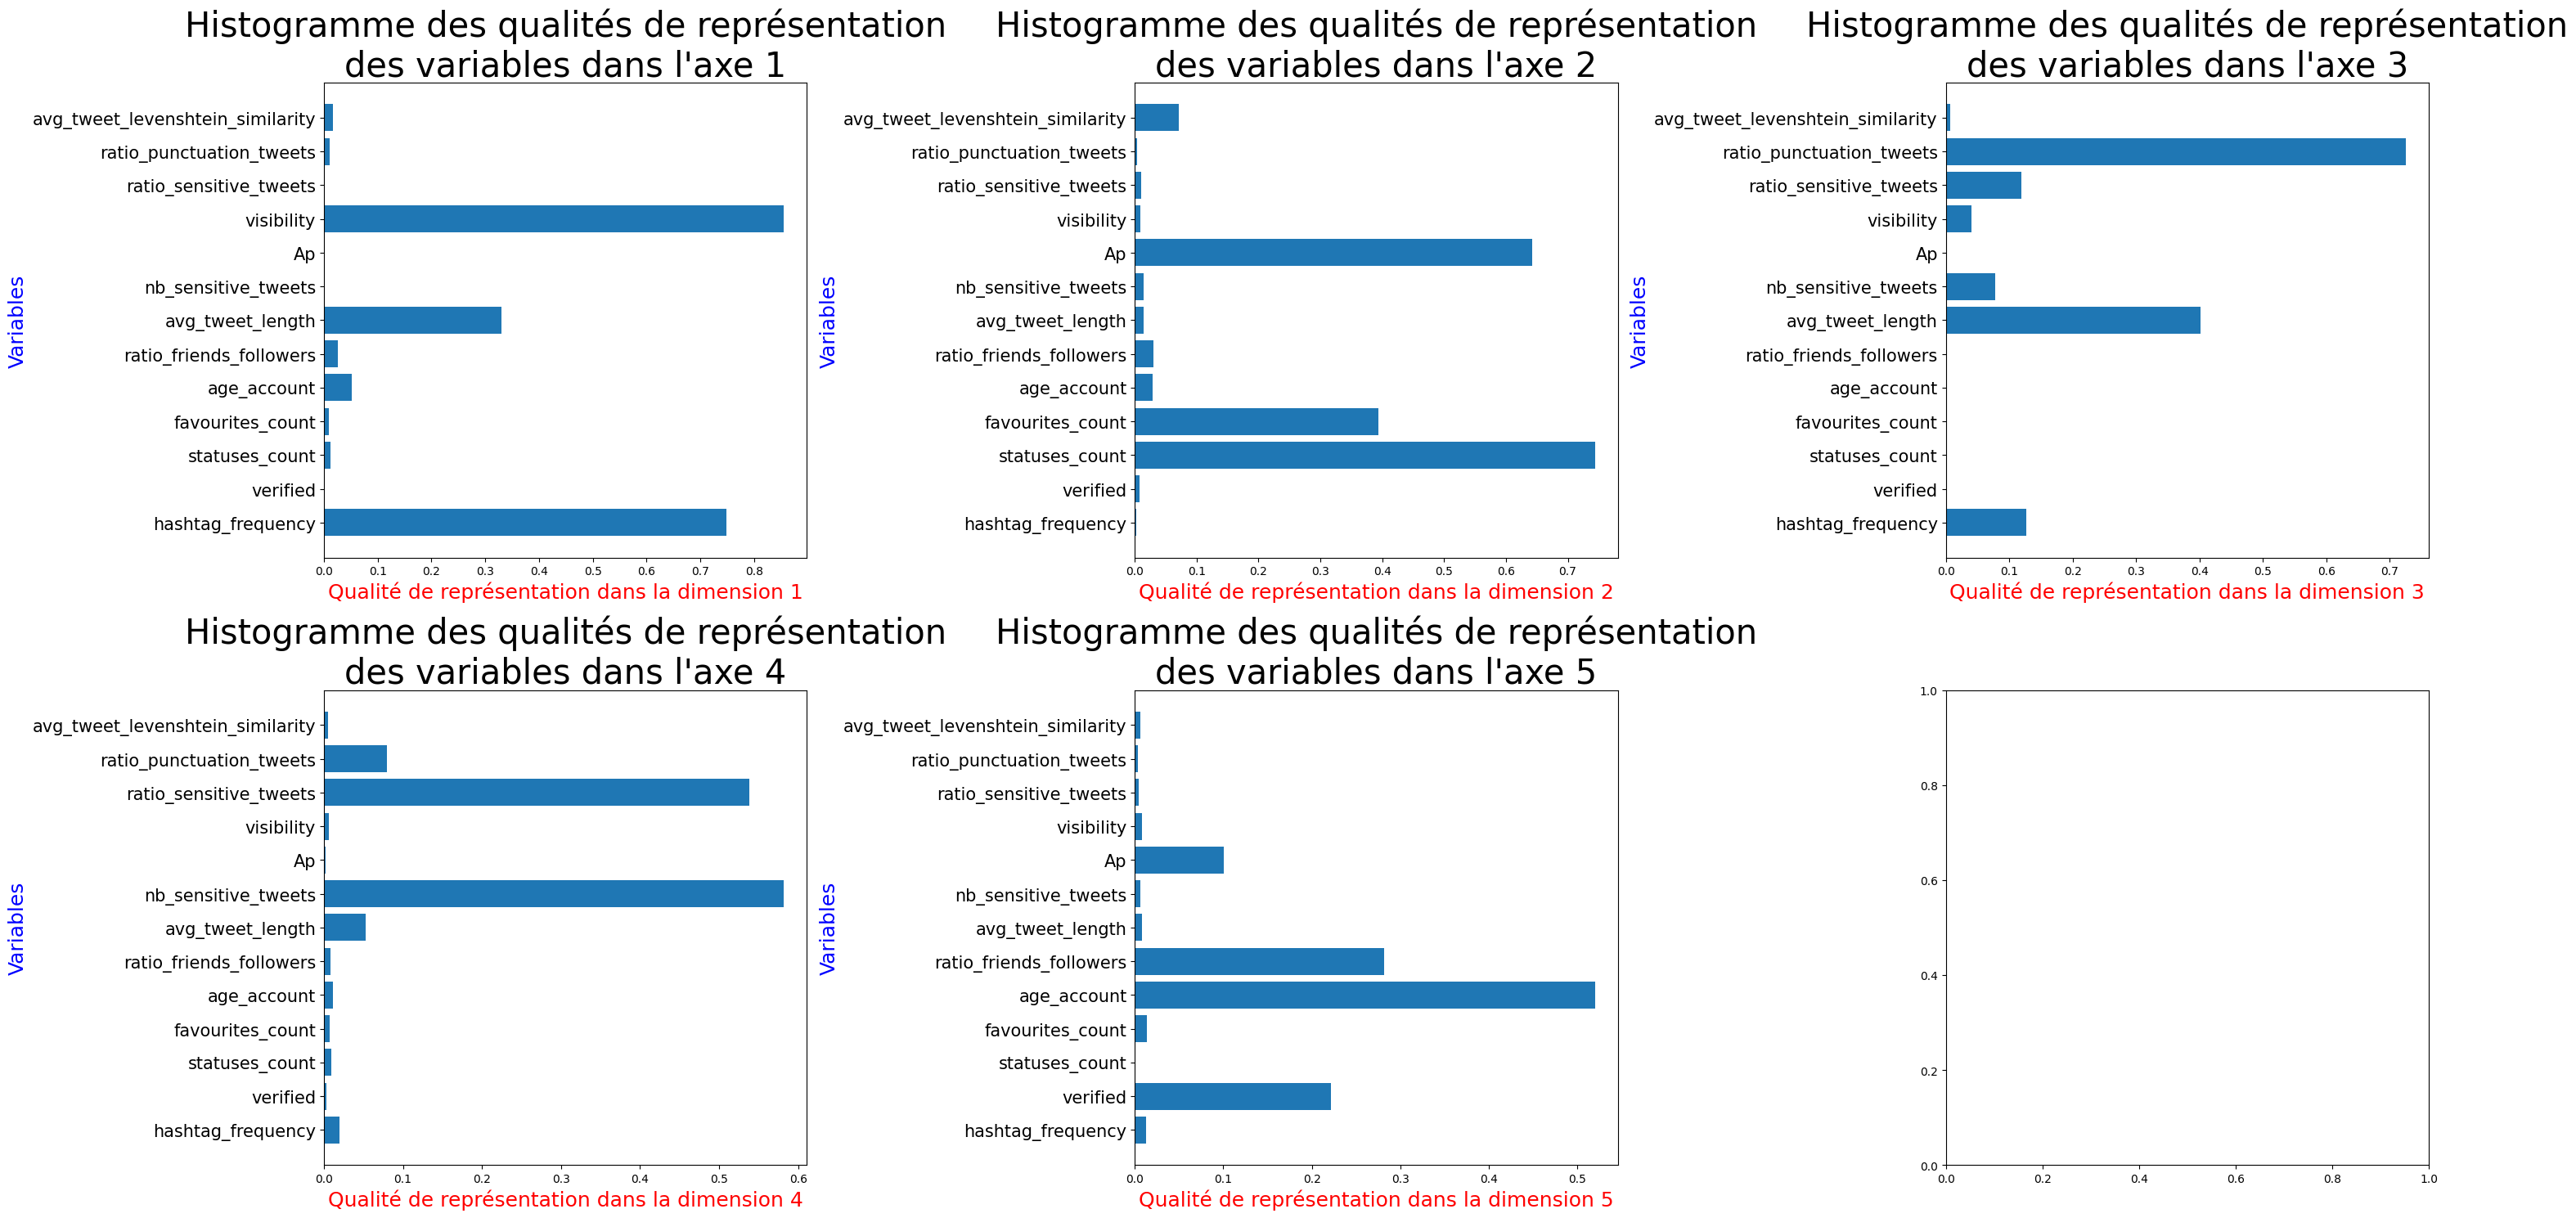

In [86]:
# Qualité de représentation des variables - COS2
cos2 = corr_var**2
var_quali_df = pd.DataFrame({f'COS2_{acp_dim+1}':cos2[:,acp_dim] for acp_dim in range(nb_composante)}, index=users.columns)


cols = 3
rows = math.ceil( (nb_composante - 1) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(30,15))

row = 0
col = -1
num_var = np.arange(len(var_quali_df))

for quali in range(len(var_quali_df.columns)):
    col += 1
    # les points
    axes[row][col].barh(num_var, var_quali_df[f'COS2_{quali+1}'], align='center')
    axes[row][col].set_yticks(num_var)
    axes[row][col].set_yticklabels(var_quali_df.index, fontsize = 15)
    axes[row][col].set_title(f'Histogramme des qualités de représentation\ndes variables dans l\'axe {quali+1}', fontsize=30)
    axes[row][col].set_xlabel(f'Qualité de représentation dans la dimension {quali+1}', fontsize=18, color = 'red')
    axes[row][col].set_ylabel(f'Variables', fontsize=18, color ='blue')
    if col % cols == cols - 1:
        col = -1
        row += 1

fig.tight_layout()
plt.show()

# Clustering

## 3. Détermination le nombre de clusters à conserver
### Méthode du coude

Pour déterminer le nombre optimal de cluster pour notre jeu de donnée, nous pouvons utiliser la méthode du coude et la Silhouette .Nous iterrerons notre algorithme  sur un intervale de nombre de cluster et nous examinerons l'inertie pour chaque nombre de classe en  suivant le principe de coude, de meme nous nous inereserons à au calcul de la sihoullette pour une prise de decision du nombre de clusters definitive

In [87]:
%%time

clusters = {}
n_cluster = range(2,10)
for k in n_cluster:
    start_time = datetime.now()
    print(f"{'-'*30}\n>>>> Start cluster k = {k}: {start_time}")
    result = {}
    
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(user_scale)
    score = silhouette_score(user_scale,model.labels_,sample_size = 100_000)
    #score = multi_core_silhouette(reduced_user_scale,model)
    
    result["model"] = model
    result["silhouette"] = score
    clusters[k] = result
    
    end_time = datetime.now()         
    print(f"End : {end_time}")
    diff_time = end_time - start_time
    print(f"Duration : {diff_time.seconds // 3600}h {(diff_time.seconds // 60) % 60}min {diff_time.seconds % 60}sec ")


------------------------------
>>>> Start cluster k = 2: 2023-06-11 16:36:48.034851
End : 2023-06-11 16:39:00.469773
Duration : 0h 2min 12sec 
------------------------------
>>>> Start cluster k = 3: 2023-06-11 16:39:00.469773
End : 2023-06-11 16:41:19.675854
Duration : 0h 2min 19sec 
------------------------------
>>>> Start cluster k = 4: 2023-06-11 16:41:19.676303
End : 2023-06-11 16:43:26.130733
Duration : 0h 2min 6sec 
------------------------------
>>>> Start cluster k = 5: 2023-06-11 16:43:26.130733
End : 2023-06-11 16:45:36.791723
Duration : 0h 2min 10sec 
------------------------------
>>>> Start cluster k = 6: 2023-06-11 16:45:36.791723
End : 2023-06-11 16:47:50.052503
Duration : 0h 2min 13sec 
------------------------------
>>>> Start cluster k = 7: 2023-06-11 16:47:50.052503
End : 2023-06-11 16:49:55.473867
Duration : 0h 2min 5sec 
------------------------------
>>>> Start cluster k = 8: 2023-06-11 16:49:55.473867
End : 2023-06-11 16:51:56.775475
Duration : 0h 2min 1sec 
--

In [88]:
score_inertie = [ clusters[k]["model"].inertia_ for k in clusters.keys()]
score_silhouette = [ clusters[k]["silhouette"] for k in clusters.keys()]

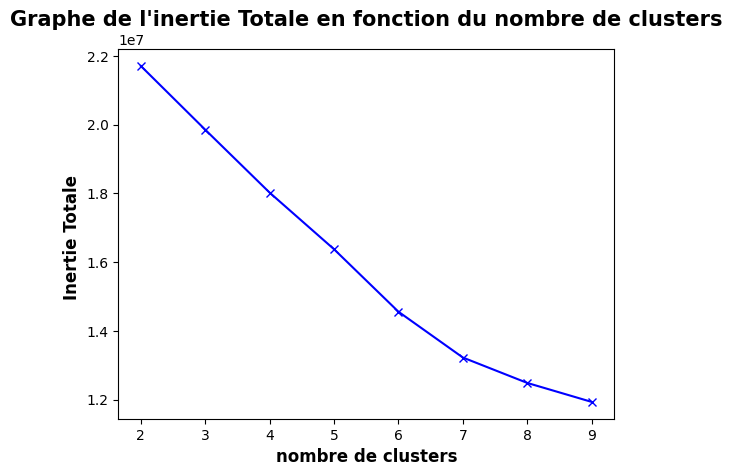

In [89]:
# Graphe de lInertie Total en fonction du nombre de cluster
plt.plot(n_cluster, score_inertie,"bx-")

#Labels
plt.xlabel("nombre de clusters", fontweight = "bold",fontsize = 12)
plt.ylabel("Inertie Totale ", fontweight = "bold",fontsize = 12)

#Titles
plt.title("Graphe de l'inertie Totale en fonction du nombre de clusters", fontweight = "bold", fontsize = 15)


plt.show()

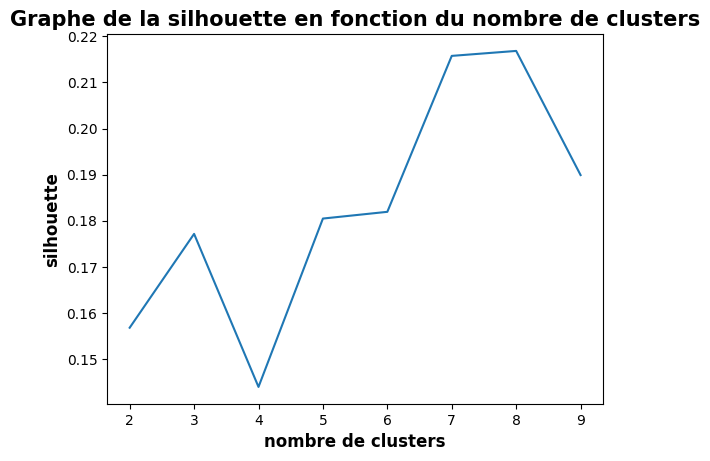

In [90]:
plt.plot(n_cluster, score_silhouette)
plt.xlabel("nombre de clusters", fontweight="bold", fontsize=12)
plt.ylabel("silhouette", fontweight="bold", fontsize=12)
plt.title("Graphe de la silhouette en fonction du nombre de clusters", fontweight="bold", fontsize=15)
plt.show()

Arrivé Ici on voit que le nombre de clusters optimal qu'on peut prendre est `4`

# KMeans Avec 4 Clusters

In [91]:
model = clusters[7]["model"]

NameError: name 'cluster' is not defined

# Visualisation et Communication des Resultat

In [ ]:
user_scale_label = np.c_[acp_coord,model.labels_]
labels = set(model.labels_)

In [ ]:
# corr_3D.shape
labels

In [ ]:
last_col = user_scale_label[:, -1]  # Extract the last column

unique_vals = np.unique(last_col)  # Get unique values from the last column

random_rows = []
num_rows = 200  # Number of rows to retrieve for each unique value

for val in unique_vals:
    rows_with_val = np.where(last_col == val)[0]  # Get indices of rows with the current value
    random_indices = np.random.choice(rows_with_val, num_rows, replace=False)  # Randomly choose indices
    random_rows.extend(random_indices)

selected_rows = user_scale_label[random_rows]  # Retrieve the selected rows

In [ ]:
# Determine the number of combinations
num_cols = selected_rows.shape[1]
num_combinations = num_cols * (num_cols - 1) * (num_cols - 2) // 6

# Create subplots for each combination
fig, axes = plt.subplots(nrows=num_combinations, ncols=1, figsize=(10, 8 * num_combinations), subplot_kw={'projection': '3d'})

# Iterate over all possible combinations of three columns
subplot_idx = 0
for i in range(num_cols - 2):
    for j in range(i + 1, num_cols - 1):
        for k in range(j + 1, num_cols):
            ax = axes[subplot_idx]
            subplot_idx += 1

            # Plotting the points with the colors
            for label in labels:
                plotted_values = selected_rows[:,-1] == label
                ax.scatter(selected_rows[plotted_values, i], selected_rows[plotted_values, j], selected_rows[plotted_values, k], label=label)

            # Setting labels for the axes
            ax.set_xlabel(f'CP{i}')
            ax.set_ylabel(f'CP{j}')
            ax.set_zlabel(f'{k}')

            ax.legend()

# Adjust the layout of subplots
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Determine the number of combinations
num_cols = selected_rows.shape[1]
num_combinations = num_cols * (num_cols - 1) * (num_cols - 2) // 6

# Create subplots for each combination
fig, axes = plt.subplots(nrows=num_combinations, ncols=1, figsize=(10, 8 * num_combinations), subplot_kw={'projection': '3d'})

# Iterate over all possible combinations of three columns
subplot_idx = 0
for i in range(num_cols - 2):
    for j in range(i + 1, num_cols - 1):
        for k in range(j + 1, num_cols):
            ax = axes[subplot_idx]
            subplot_idx += 1

            # Plotting the points with the colors
            for label in labels:
                plotted_values = selected_rows[:,-1] == label
                ax.scatter(selected_rows[plotted_values, i], selected_rows[plotted_values, j], selected_rows[plotted_values, k], label=label)

            # Setting labels for the axes
            ax.set_xlabel(f'CP{i}')
            ax.set_ylabel(f'CP{j}')
            ax.set_zlabel(f'{k}')

            ax.legend()
            ax.view_init(elev=190, azim=45)

# Adjust the layout of subplots
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
print("Nombre d'individus par label")
for label in labels:
    filtered_values = user_scale_label[:,-1] == label
    print(label," : ",np.count_nonzero(filtered_values))

In [ ]:
users_acp_label = pd.concat((users.reset_index(drop=True),pd.DataFrame(acp_coord)), axis=1)
users_acp_label .columns.values[-nb_composante:] = liste[:nb_composante]
users_acp_label ["KMeans_labals"] = model.labels_

In [ ]:
xgb = users.groupby(model.labels_).mean()

#Plot
xgb.plot(kind = "bar")

#Labels
plt.xlabel("Cluster")
plt.ylabel("Value ")

#Title
plt.title("valeures moyenne des composantes");

# Interpretations